# Pacific Decadal Oscillation

In this notebook, I used the Pacific Decadal Oscillation SST Anomaly from https://psl.noaa.gov/gcos_wgsp/Timeseries/PDO/ to compare to the melting layer time series.

#### Import modules

In [18]:
%pylab inline

import pyart
import pandas as pd
import numpy as np
import seaborn as sns

import os

import datetime as dt
import pytz

import sys, os

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Populating the interactive namespace from numpy and matplotlib


#### Load data

I downloaded the data [here](https://psl.noaa.gov/gcos_wgsp/Timeseries/Data/pdo.long.data) _(Last accessed: 04/27/2021)_ and saved it to my local directory. There is probably a way to read the data directly from the site into a pandas dataframe, but this is how I did it for now.

In [3]:
# file path
pdo_datfile = '/home/icrisologo/Data/pdo.long.data'

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Because the data is in a fixed-width format, I used `pd.read_fwf` to read it, skipped reading the first row because it just says the start and end years. I set the index to the 0th column so that the index is the year.

I also dropped the last 10 rows because they just contain other info.

In [4]:
df = pd.read_fwf(pdo_datfile,sep='\t',skiprows=(1),header=None,index_col=[0])
df.drop(df.tail(10).index,inplace=True) # drop last 10 rows (other info)

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


I want the index to have only the year, so that I can filter by year. First, the index column name is renamed to `Year`, then it is converted to a datetime object, which gets the format "Year-month-day". Since I want only the year, I select only the year object.

In [5]:
df.index = df.index.rename('Year')
# Converting the index as date
df.index = pd.to_datetime(df.index, format='%Y-%m-%d').year

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now I can select only years from 1996 onwards.

In [6]:
df = df.loc[df.index>1995]

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


For easier filtering, I also renamed the columns as the month number in string format.

In [7]:
df.columns = ['1', '2','3','4','5','6','7','8','9','10','11','12']

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Re-arranging by California wet season

Because the wet season of California is from October 1 to April 1 of the following year, it would be helpful to rearrange the dataframe such that each row is one wet season. The wet season is designated by the calendar year in which it ends, so that October 1995 to March 1996 is the 1996 wet season.

In [40]:
df_wateryear = pd.DataFrame()#(columns=[10,11,12,1,2,3])
for y in df.index:
    wateryear_half1 = df.loc[(df.index==y)][['10','11','12']]
    wateryear_half2 = df.loc[(df.index==y+1)][['1', '2','3','4','5','6','7','8','9']]
    wateryear_half2.rename(index={y+1:y},inplace=True)
    wateryear = pd.merge(wateryear_half1,wateryear_half2,how='outer',on='Year')
    df_wateryear = pd.concat([df_wateryear,wateryear])

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Let's have a preview.

In [41]:
df_wateryear.head()

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,10,11,12,1,2,3,4,5,6,7,8,9
Year,,,,,,,,,,,,
1996,-0.33,0.09,-0.03,0.23,0.28,0.65,1.05,1.83,2.76,2.35,2.79,2.19
1997,1.61,1.12,0.67,0.83,1.56,2.01,1.27,0.70,0.40,-0.04,-0.22,-1.21
1998,-1.39,-0.52,-0.44,-0.32,-0.66,-0.33,-0.41,-0.68,-1.30,-0.66,-0.96,-1.53
1999,-2.23,-2.05,-1.63,-2.00,-0.83,0.29,0.35,-0.05,-0.44,-0.66,-1.19,-1.24
2000,-1.30,-0.53,0.52,.60,.29,0.45,-0.31,-0.30,-0.47,-1.31,-0.77,-1.37


In [42]:
df_wateryear['Year'] = df_wateryear.index

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
df_wateryear.head()

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,10,11,12,1,2,3,4,5,6,7,8,9,Year
Year,,,,,,,,,,,,,
1996,-0.33,0.09,-0.03,0.23,0.28,0.65,1.05,1.83,2.76,2.35,2.79,2.19,1996
1997,1.61,1.12,0.67,0.83,1.56,2.01,1.27,0.70,0.40,-0.04,-0.22,-1.21,1997
1998,-1.39,-0.52,-0.44,-0.32,-0.66,-0.33,-0.41,-0.68,-1.30,-0.66,-0.96,-1.53,1998
1999,-2.23,-2.05,-1.63,-2.00,-0.83,0.29,0.35,-0.05,-0.44,-0.66,-1.19,-1.24,1999
2000,-1.30,-0.53,0.52,.60,.29,0.45,-0.31,-0.30,-0.47,-1.31,-0.77,-1.37,2000


#### Trend over the years

I'm reshaping the dataframe so that it would be easier to plot. To reshape, I used `DataFrame.melt`, set the variable name as Month and the value name as PDO_anomaly.

In [46]:
df_ = df_wateryear.melt(id_vars='Year', var_name='Month', value_name='PDO_anomaly')

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Converting the values to float because they were stored as string.

In [47]:
df_['Month'] = df_['Month'].astype(float)
df_['PDO_anomaly'] = df_['PDO_anomaly'].astype(float)

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Plotting!

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


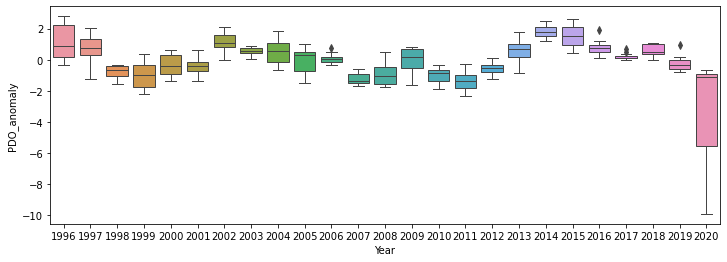

In [48]:
fig, ax = pyplot.subplots(figsize =(12, 4)) 
ax = sns.boxplot(x="Year", y="PDO_anomaly", 
                 data=df_, linewidth=1)

#### Export dataframe

Save the dataframe as a csv file so it can be plotted with other dataframes in a different notebook.

In [49]:
df_.to_csv("pdo_anomaly.csv")

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
